In [1]:
from master_thesis.src import models, utils, data
from master_thesis.experiments.regression import predict
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50) # make all columns visible

In [2]:
df_full = utils.get_raw_df()

Shape of raw df: (84887, 71)


/home/ruecker/miniconda3/envs/GPU/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3242: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [3]:
df_full.columns

Index(['articleId', 'pageviews', 'entrances', 'exits', 'bounces', 'timeOnPage',
       'conversions', 'avgTimeOnPage', 'stickiness', 'entranceRate',
       'bounceRate', 'sharePageviews', 'n', 'nObs', 'score_pageviews',
       'score_avgTimeOnPage', 'score_entranceRate', 'score_stickiness',
       'SCORE', 'kategorie', 'rubrik', 'subRubrik', 'titel', 'pagePath',
       'dpaGuid', 'zeilen', 'prozentDpa', 'prozentVerlag', 'categoryCode',
       'creationDate', 'flextags', 'genre', 'geoArea', 'importance',
       'keywords', 'lifetime', 'limbic', 'links', 'picture', 'service',
       'subject', 'subjectBroader', 'subjectCode', 'teaser', 'text', 'titelH1',
       'titelH3', 'urgency', 'wikidata', 'wordcount', 'category', 'ratgeber',
       'format', 'dateLoaded', 'nLoadAttempts', 'ausreisser', 'publisher',
       'city', 'text_preprocessed', 'nr_tokens', 'mean_token_length',
       'nr_tokens_teaser', 'nr_tokens_titelH1', 'nr_char', 'nr_sentences',
       'mean_sentence_length', 'avgTimeOn

In [4]:
use_columns = ['articleId', 'pageviews', 'pageviews-exits', 'timeOnPage', 'avgTimeOnPage', 'stickiness', 'category', 'pagePath',
               'teaser', 'text', 'titel', 'titelH1', 'zeilen', 'wordcount', 'nr_tokens', 'prozentDpa', 'prozentVerlag', 'publisher', 'text_preprocessed', 
               'nr_char', 'nr_sentences', 'mean_sentence_length', 'avgTimeOnPagePerWordcount', 'avgTimeOnPagePerRow', 'tokensPerMinute',
               'ausreisser']
df_full = df_full[use_columns]

In [5]:
#df_full.set_index('articleId', inplace=True)
df_full.shape

(84887, 26)

In [6]:
df_full.set_index('articleId', inplace=True)

In [7]:
df_full.head(2)

,pageviews,pageviews-exits,timeOnPage,avgTimeOnPage,stickiness,category,pagePath,teaser,text,titel,titelH1,zeilen,wordcount,nr_tokens,prozentDpa,prozentVerlag,publisher,text_preprocessed,nr_char,nr_sentences,mean_sentence_length,avgTimeOnPagePerWordcount,avgTimeOnPagePerRow,tokensPerMinute,ausreisser
articleId,,,,,,,,,,,,,,,,,,,,,,,,,
49297055,109,78,7165,91.858974,71.559633,vm,https://www.general-anzeiger-bonn.de/news/pano...,NaN,Essen (dpa) - Nach dem schweren Unfall in Esse...,unfall-an-strassenbahn-halt-verletzte-noch-in-...,Nach Unfall an Haltestelle in Essen noch ein M...,18,142,139,100,52,bonn,"Nach dem schweren Unfall in Essen, bei dem am ...",970,11.0,12.636364,0.646894,5.103276,92.750872,nein
49307861,5,1,58,58.000000,20.000000,sp,https://www.general-anzeiger-bonn.de/sport/sie...,Dank eines 2:0-Sieges im Clásico gegen den FC ...,Madrid (dpa) - Real Madrid hat den 180. Clásic...,sieg-im-clasico-real-uebernimmt-tabellenfuehru...,Sieg im Clásico: Real übernimmt Tabellenführun...,41,303,304,73,60,bonn,Real Madrid hat den 180. Clásico in der spanis...,2026,21.0,14.476190,0.191419,1.414634,313.448276,nein


In [15]:
# only those with more than 50 pageviews and ...
df = df_full[(df_full['pageviews-exits'] >= 50) & 
             (df_full.wordcount >= 10) &
             (df_full.wordcount <= 1500) &
             (df_full.ausreisser == 'nein') &
             (df_full.avgTimeOnPage > 2) &
             (df_full.avgTimeOnPage < 600) &
             (df_full.avgTimeOnPagePerWordcount >= 0.01) &
             (df_full.avgTimeOnPagePerWordcount <= 3) &
             (df_full.tokensPerMinute <= 600)
             ] 

print(df.shape)

(9566, 25)


In [16]:
df.ausreisser.value_counts()

nein    9566
Name: ausreisser, dtype: int64

In [177]:
display_columns = ['pageviews', 'stickiness', 'timeOnPage', 'avgTimeOnPagePerWordcount', 'tokensPerMinute', 'nr_tokens' 'nr_sentences']


In [178]:
df.describe().round(2)

,pageviews,timeOnPage,avgTimeOnPage,stickiness,wordcount,nr_tokens,nr_char,nr_sentences,mean_sentence_length,avgTimeOnPagePerWordcount,tokensPerMinute,zeilen
count,20018.00,20018.00,20018.00,20018.00,20018.00,20018.00,20018.00,20018.00,20018.00,20018.00,20018.00,20018.00
mean,692.92,40818.35,148.34,50.15,386.86,396.06,2759.10,23.04,17.50,0.50,185.56,46.40
std,4536.10,240544.80,75.58,17.46,224.60,231.63,1616.24,13.73,3.25,0.37,123.47,27.86
min,50.00,98.00,13.41,1.77,35.00,34.00,251.00,2.00,5.74,0.10,20.02,0.00
25%,74.00,4532.25,96.17,37.31,199.00,202.00,1410.25,12.00,15.33,0.24,92.28,23.00
50%,130.00,9276.50,137.68,52.08,322.00,329.00,2310.00,19.00,17.12,0.40,151.83,40.00
75%,355.00,25437.50,185.34,63.89,549.00,564.00,3919.00,32.00,19.25,0.65,245.40,65.00
max,395458.00,25149922.00,596.55,96.15,1463.00,1499.00,10901.00,100.00,43.09,3.00,599.71,218.00


In [179]:
df.sort_values(by=['avgTimeOnPagePerWordcount'], ascending = False)
#df.sort_values(by=['tokensPerMinute'], ascending = False)

,pageviews,timeOnPage,avgTimeOnPage,stickiness,category,pagePath,teaser,text,titelH1,wordcount,nr_tokens,publisher,text_preprocessed,nr_char,nr_sentences,mean_sentence_length,avgTimeOnPagePerWordcount,tokensPerMinute,zeilen,ausreisser
articleId,,,,,,,,,,,,,,,,,,,,
1982244,121,13124,596.545455,18.181818,vm,https://www.noz.de/deutschland-und-welt/vermis...,NaN,Los Angeles (dpa) - Popstar Taylor Swift (30) ...,Taylor-Swift-Doku «Miss Americana» - erster Tr...,199,210,NOZ,Popstar Taylor Swift (30) hat den ersten Trail...,1267,12.0,17.500000,2.997716,20.015239,20,nein
1953000,2109,128080,337.052632,18.018018,pl,https://www.noz.de/deutschland-und-welt/vermis...,NaN,Sebnitz (dpa) - Zwei Jugendliche sollen im säc...,Polizei: Jugendliche attackieren Elfjährige au...,113,112,NOZ,Zwei Jugendliche sollen im sächsischen Sebnitz...,749,8.0,14.000000,2.982767,20.115553,11,nein
49693729,2982,219612,166.121000,44.332660,pl,https://www.general-anzeiger-bonn.de/news/poli...,NaN,Berlin (dpa) - Bundeskanzlerin Angela Merkel (...,Merkel muss wegen Kontakt zu Corona-Infizierte...,56,53,bonn,Bundeskanzlerin Angela Merkel (CDU) muss sich ...,375,3.0,17.666667,2.966446,20.226221,4,nein
52976309,132,8777,132.984848,50.000000,wi,https://www.aachener-zeitung.de/wirtschaft/rei...,NaN,Berlin (dpa) - Die Bundesregierung hat die Rei...,Reisewarnung für mehr als 160 Länder bis 14. S...,45,42,aachener,Die Bundesregierung hat die Reisewarnung für T...,307,3.0,14.000000,2.955219,20.303065,4,nein
1970360,5880,370624,389.310924,16.190476,vm,https://www.noz.de/deutschland-und-welt/vermis...,NaN,Georgensgmünd (dpa) - Nach dem schweren Verkeh...,Drei Tote nach Unfall in Mittelfranken - auch ...,132,129,NOZ,Nach dem schweren Verkehrsunfall bei Georgensg...,902,7.0,18.428571,2.949325,20.343637,13,nein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49610905,303,5344,28.886486,61.056106,pl,https://www.saarbruecker-zeitung.de/nachrichte...,"Es ist absehbar, dass für die Corona-Infiziert...",Berlin (dpa) - Angesichts steigender Zahlen an...,Notfallplan für Kliniken - Mehr Betten durch U...,288,293,SZ,Angesichts steigender Zahlen an Corona-Infizie...,2320,12.0,24.416667,0.100300,598.203593,39,nein
49139381,194,3719,44.807229,42.783505,wi,https://www.saarbruecker-zeitung.de/nachrichte...,NaN,Frankfurt/Main (dpa) - Die rasche Ausbreitung ...,Alarmstimmung an der Börse wegen rasanter Viru...,447,447,SZ,Die rasche Ausbreitung des Coronavirus in Länd...,3023,30.0,14.900000,0.100240,598.564130,48,nein
47952981,74,1374,49.071429,37.837838,sp,https://www.saarbruecker-zeitung.de/sport/fuss...,Wenn Köln und Bremen im Keller-Duell aufeinand...,Köln (dpa) - Als vor der Saison alle über Flor...,Plötzliche Wendung: Gisdol mit Köln Favorit ge...,490,506,SZ,Als vor der Saison alle über Florian Kohfeldt ...,3199,29.0,17.448276,0.100146,599.126638,44,nein


In [180]:
df[abs(df.wordcount - df.nr_tokens)/df.wordcount > 0.2] # nothing too crazy here

,pageviews,timeOnPage,avgTimeOnPage,stickiness,category,pagePath,teaser,text,titelH1,wordcount,nr_tokens,publisher,text_preprocessed,nr_char,nr_sentences,mean_sentence_length,avgTimeOnPagePerWordcount,tokensPerMinute,zeilen,ausreisser
articleId,,,,,,,,,,,,,,,,,,,,
48892351,77,3264,141.913000,29.870130,vm,https://www.general-anzeiger-bonn.de/news/pano...,NaN,Berlin (dpa) - Für Schauspielerin Annika Ernst...,Annika Ernst: Berlin ist «die Partyhauptstadt ...,114,138,bonn,Für Schauspielerin Annika Ernst («In aller Fre...,778,7.0,19.714286,1.244851,48.198544,15,nein
1962766,97,2783,38.123288,75.257732,sp,https://www.noz.de/deutschland-und-welt/nieder...,NaN,Wolfsburg (dpa) - Fußball-Bundesligist VfL Wol...,VfL Wolfsburg droht beim FC Bayern Ausfall von...,148,180,NOZ,Fußball-Bundesligist VfL Wolfsburg muss zum Ab...,1230,9.0,20.000000,0.257590,232.928494,12,nein
1970167,52,3962,99.050000,76.923077,vm,https://www.noz.de/deutschland-und-welt/vermis...,NaN,Los Angeles (dpa) - Der britische Rocker Rod S...,Rod Stewart muss nach angeblicher Handgreiflic...,139,171,NOZ,Der britische Rocker Rod Stewart (74) und sein...,1101,12.0,14.250000,0.712590,84.199899,19,nein
1970298,1430,49980,49.096267,71.188811,vm,https://www.noz.de/deutschland-und-welt/vermis...,NaN,Los Angeles (dpa) - Der britische Rocker Rod S...,Rod Stewart muss nach angeblicher Handgreiflic...,139,171,NOZ,Der britische Rocker Rod Stewart (74) und sein...,1101,12.0,14.250000,0.353211,169.870348,23,nein
49721527,51,3688,92.200000,78.431373,vm,https://www.aachener-zeitung.de/panorama/hilar...,NaN,Berlin (dpa) - US-Schauspieler Alec Baldwin (6...,Hilaria Baldwin: Musste sechs Wochen auf erste...,142,171,aachener,US-Schauspieler Alec Baldwin (61) hat seine Eh...,1035,9.0,19.000000,0.649296,92.407809,18,nein
48617581,76,2190,87.600000,32.894737,sp,https://www.saarbruecker-zeitung.de/sport/spor...,"Training, Fitnessstudio, Playstation und Live-...",Miami/Rothenburg ob der Tauber (dpa) - Sebasti...,Ein Leben für den Football: Der Kosmos von Sup...,430,524,SZ,Sebastian Vollmer und Markus Koch haben als De...,3391,27.0,19.407407,0.203721,294.520548,61,nein


In [181]:
df.loc[49802509].text

'Nürnberg (dpa) - Deutschland steuert wegen der Corona-Krise auf\nschwere wirtschaftliche Zeiten zu: Die Volkswirte führender deutscher\nFinanzorganisationen sagen einen herben Einbruch der\nWirtschaftsleistung um rund fünf Prozent voraus - ähnlich dem nach\nder Finanzkrise 2009. Dabei gehen sie in ihren Rechenmodellen davon\naus, dass um Anfang Mai herum wieder weitgehend gearbeitet werden\nkann - in den Augen von Medizinern eine optimistische Sicht auf die\nDinge. «Um die Ausbreitung des Covid-19-Virus zu verlangsamen, muss\ndie deutsche Wirtschaft derzeit eine notwendige Atempause einlegen,\ndie voraussichtlich ein bis zwei Monate dauern wird», sagte Katharina\nUtermöhl von der Allianz-Gruppe in einer Umfrage der Deutschen\nPresse-Agentur (dpa). \n\n«Es wird runtergehen, aber wir wissen nicht, wie weit», sagte\nJens-Oliver Niklasch von der Landesbank Baden-Württemberg (LBBW).\nNach Abklingen der Pandemie werde die Industrie in Deutschland\nvoraussichtlich nicht im selben Tempo hochf

In [182]:
df.loc[49802509].text_preprocessed

'Deutschland steuert wegen der Corona-Krise auf schwere wirtschaftliche Zeiten zu: Die Volkswirte führender deutscher Finanzorganisationen sagen einen herben Einbruch der Wirtschaftsleistung um rund fünf Prozent voraus - ähnlich dem nach der Finanzkrise 2009. Dabei gehen sie in ihren Rechenmodellen davon aus, dass um Anfang Mai herum wieder weitgehend gearbeitet werden kann - in den Augen von Medizinern eine optimistische Sicht auf die Dinge. «Um die Ausbreitung des Covid-19-Virus zu verlangsamen, muss die deutsche Wirtschaft derzeit eine notwendige Atempause einlegen, die voraussichtlich ein bis zwei Monate dauern wird», sagte Katharina Utermöhl von der Allianz-Gruppe in einer Umfrage der Deutschen Presse-Agentur «Es wird runtergehen, aber wir wissen nicht, wie weit», sagte Jens-Oliver Niklasch von der Landesbank Baden-Württemberg (LBBW). Nach Abklingen der Pandemie werde die Industrie in Deutschland voraussichtlich nicht im selben Tempo hochfahren, wie sie jetzt runterfährt. Denn die

In [183]:
#df.loc[48369995].text_preprocessed # 48369995

In [184]:
print(st.pearsonr(df.nr_tokens, df.avgTimeOnPage))
print(st.pearsonr(df.wordcount, df.avgTimeOnPage))
# korreliert gar nicht sooo sehr, also vielleicht einfach unnormierte avgTimeOnPage nehmen?

(0.2930372365611257, 0.0)
(0.29297005803950155, 0.0)


(0.2930372365611257, 0.0)


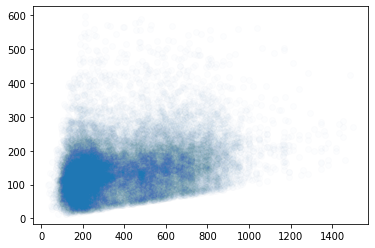

In [185]:
plt.scatter(df.nr_tokens, df.avgTimeOnPage, alpha=0.01)
print(st.pearsonr(df.nr_tokens, df.avgTimeOnPage))

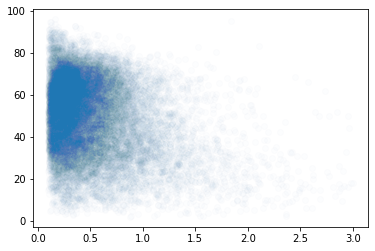

In [186]:
plt.scatter(df.avgTimeOnPagePerWordcount, df.stickiness, alpha = 0.01)

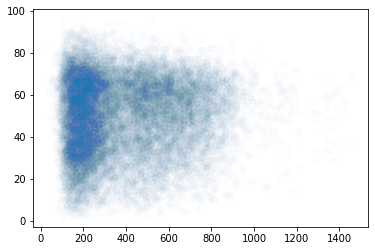

In [187]:
plt.scatter(df.wordcount, df.stickiness, alpha = 0.01)

In [3]:
print(st.pearsonr(df.wordcount, df.tokensPerMinute))
print(st.pearsonr(df.wordcount, df.avgTimeOnPagePerWordcount))

plt.scatter(df.wordcount, df.tokensPerMinute, alpha = 0.01)
#plt.scatter(df.wordcount, df.avgTimeOnPagePerWordcount, alpha = 0.01)

# sieht man hier einen Zusammenhang? Das sollte ja eigentlich nicht so sehr korrelieren
# wobei: je länger der Artikel, desto weniger ganz liest man ihn, also sinkt die avgTimeOnPagePerWordcount

NameError: name 'df' is not defined

(array([1503., 1686., 1832., 1808., 1586., 1447., 1168., 1060.,  968.,
         877.,  788.,  688.,  606.,  525.,  452.,  413.,  337.,  271.,
         250.,  205.,  190.,  182.,  137.,  132.,   97.,  116.,   76.,
          66.,   68.,   54.,   48.,   39.,   37.,   33.,   28.,   27.,
          24.,   20.,   26.,   23.,   15.,   10.,   11.,    8.,    6.,
          10.,   13.,    6.,    5.,    6.,    4.,    3.,    5.,    3.,
           2.,    2.,    3.,    5.,    4.,    4.]),
 array([0.1000481 , 0.14834256, 0.19663703, 0.24493149, 0.29322595,
        0.34152041, 0.38981488, 0.43810934, 0.4864038 , 0.53469826,
        0.58299273, 0.63128719, 0.67958165, 0.72787611, 0.77617058,
        0.82446504, 0.8727595 , 0.92105396, 0.96934843, 1.01764289,
        1.06593735, 1.11423181, 1.16252628, 1.21082074, 1.2591152 ,
        1.30740966, 1.35570413, 1.40399859, 1.45229305, 1.50058751,
        1.54888198, 1.59717644, 1.6454709 , 1.69376536, 1.74205983,
        1.79035429, 1.83864875, 1.88694321, 1.

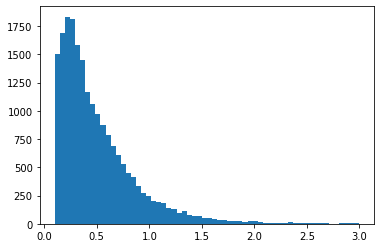

In [189]:
plt.hist(df.avgTimeOnPagePerWordcount, 60)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f50f4bcf210>,
 'caps': [<matplotlib.lines.Line2D at 0x7f50f57d85d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f50f57d3950>],
 'medians': [<matplotlib.lines.Line2D at 0x7f50f57d8e90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f50f57c2310>],
 'means': []}

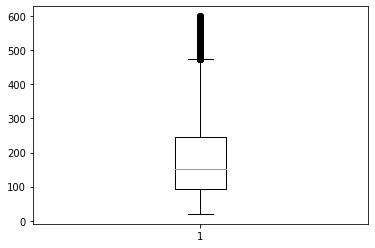

In [190]:
#plt.boxplot(df.avgTimeOnPagePerWordcount)
plt.boxplot(df.tokensPerMinute)

(array([ 13.,  22.,  39.,  52.,  74., 106., 101., 115., 145., 158., 176.,
        197., 222., 252., 265., 316., 322., 374., 403., 424., 460., 484.,
        483., 516., 509., 469., 494., 529., 536., 557., 548., 651., 603.,
        621., 611., 710., 652., 738., 740., 685., 755., 658., 590., 566.,
        474., 373., 302., 248., 193., 126.,  91.,  84.,  45.,  49.,  35.,
         29.,  13.,   8.,   3.,   4.]),
 array([ 1.7699115 ,  3.34297708,  4.91604266,  6.48910824,  8.06217381,
         9.63523939, 11.20830497, 12.78137055, 14.35443612, 15.9275017 ,
        17.50056728, 19.07363286, 20.64669843, 22.21976401, 23.79282959,
        25.36589517, 26.93896074, 28.51202632, 30.0850919 , 31.65815748,
        33.23122305, 34.80428863, 36.37735421, 37.95041979, 39.52348536,
        41.09655094, 42.66961652, 44.2426821 , 45.81574767, 47.38881325,
        48.96187883, 50.53494441, 52.10800998, 53.68107556, 55.25414114,
        56.82720672, 58.40027229, 59.97333787, 61.54640345, 63.11946903,
      

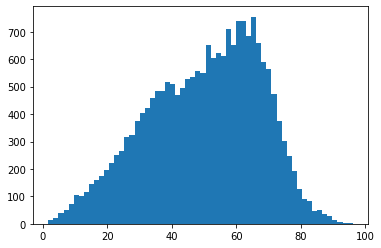

In [191]:
plt.hist(df.stickiness, 60)

(array([1.600e+01, 6.400e+01, 3.840e+02, 7.910e+02, 1.270e+03, 1.277e+03,
        1.328e+03, 1.315e+03, 1.069e+03, 9.910e+02, 7.730e+02, 6.740e+02,
        6.170e+02, 4.470e+02, 5.190e+02, 4.750e+02, 5.160e+02, 4.940e+02,
        5.980e+02, 5.130e+02, 5.530e+02, 4.700e+02, 4.780e+02, 4.910e+02,
        4.450e+02, 3.990e+02, 4.430e+02, 3.530e+02, 3.760e+02, 2.700e+02,
        2.670e+02, 3.140e+02, 1.980e+02, 1.840e+02, 1.550e+02, 1.040e+02,
        8.300e+01, 7.300e+01, 3.800e+01, 3.500e+01, 1.800e+01, 2.300e+01,
        1.000e+01, 1.300e+01, 1.200e+01, 6.000e+00, 2.400e+01, 9.000e+00,
        5.000e+00, 5.000e+00, 1.000e+00, 6.000e+00, 2.000e+00, 8.000e+00,
        3.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 2.000e+00]),
 array([  34.        ,   58.41666667,   82.83333333,  107.25      ,
         131.66666667,  156.08333333,  180.5       ,  204.91666667,
         229.33333333,  253.75      ,  278.16666667,  302.58333333,
         327.        ,  351.41666667,  375.83333333,  

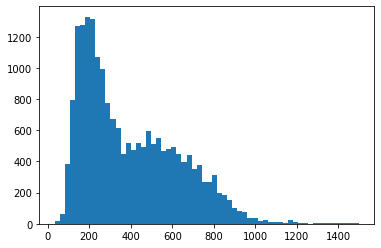

In [192]:
plt.hist(df.nr_tokens, 60)

(array([ 127.,  332.,  544.,  722.,  843.,  973., 1009.,  952.,  971.,
         882.,  815.,  735.,  701.,  641.,  693.,  585.,  558.,  559.,
         506.,  496.,  435.,  433.,  375.,  377.,  371.,  296.,  270.,
         259.,  251.,  214.,  241.,  197.,  195.,  178.,  148.,  149.,
         138.,  124.,  127.,  117.,   82.,  100.,  103.,  101.,   79.,
          80.,   85.,   89.,   96.,   64.,   69.,   82.,   72.,   58.,
          48.,   57.,   60.,   55.,   60.,   39.]),
 array([ 20.01523926,  29.67684424,  39.33844923,  49.00005422,
         58.6616592 ,  68.32326419,  77.98486918,  87.64647416,
         97.30807915, 106.96968414, 116.63128912, 126.29289411,
        135.9544991 , 145.61610408, 155.27770907, 164.93931406,
        174.60091904, 184.26252403, 193.92412902, 203.585734  ,
        213.24733899, 222.90894398, 232.57054896, 242.23215395,
        251.89375894, 261.55536393, 271.21696891, 280.8785739 ,
        290.54017889, 300.20178387, 309.86338886, 319.52499385,
        32

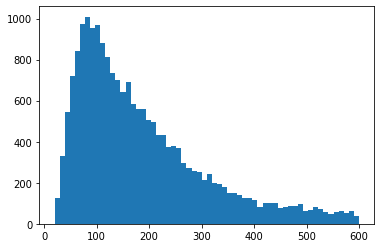

In [193]:
plt.hist(df.tokensPerMinute, 60)

bonn
0.5174384530244519
166.9078960977258
NOZ
0.6788580308599326
124.42291825768065
aachener
0.4189962924390258
193.86222799157224
SZ
0.2989658017980128
290.7927262602575
TV
0.304105161540745
285.7176139671435


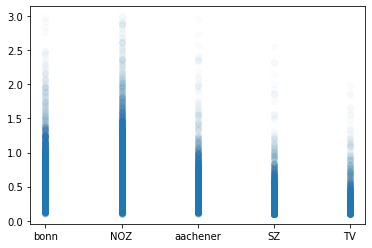

In [194]:
plt.scatter(df.publisher, df.avgTimeOnPagePerWordcount, alpha = 0.02)
#plt.scatter(df.publisher, df.tokensPerMinute, alpha = 0.02)
for p in ["bonn", "NOZ", "aachener", "SZ", "TV"]:
    print(p)
    print(np.mean(df[df.publisher == p].avgTimeOnPagePerWordcount))
    print(np.mean(df[df.publisher == p].tokensPerMinute))

bonn
1121.5486670799753
NOZ
703.2075612671847
aachener
355.34723618090453
SZ
443.9392905866303
TV
648.8215873015873


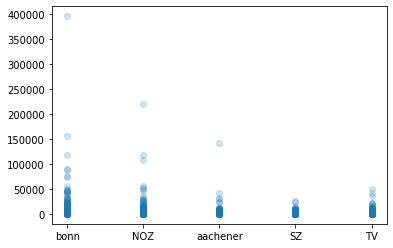

In [195]:
plt.scatter(df.publisher, df.pageviews, alpha = 0.2)
for p in ["bonn", "NOZ", "aachener", "SZ", "TV"]:
    print(p)
    print(np.mean(df[df.publisher == p].pageviews))

In [20]:
import random
ID = random.choice(df.index.values)
#ID = 2102485
print("ID", ID)
for v in ['titelH1', 'pageviews', 'publisher', 'teaser', 'text', 'pagePath', 
          'avgTimeOnPage', 'zeilen', 'wordcount', 'avgTimeOnPagePerWordcount', 'tokensPerMinute', 'stickiness']:
    print("--", v, "--\t", df.loc[ID, v])

ID 49679573
-- titelH1 --	 Über 10 000 Coronavirus-Tote - Verdopplung der Nachweise in 12 Tagen
-- pageviews --	 207
-- publisher --	 TV
-- teaser --	 Die Fallzahlen der Corona-Pandemie entwickeln sich so rasant, dass man der Entwicklung kaum zu folgen vermag. So groß die derzeitigen Zahlen schon scheinen mögen - es ist vielerorts von weiter schwindelerregend schnell in die Höhe schnellenden Werten auszugehen.
-- text --	 Baltimore/Genf (dpa) - Das Coronavirus hat nach den Daten aus
offiziellen Statistiken nun weltweit mehr als 10 000 Menschen den Tod
gebracht. Die private Johns Hopkins University im US-Staat Maryland
führte in ihrer Liste auf ihrer Homepage am Freitagmittag 10 038
Tote. Die tatsächliche Zahl abseits der offiziellen Statistiken
dürfte deutlich höher liegen, schätzen Experten. 

Mehr als 246 000 Menschen (Stand 13 Uhr) infizierten sich den von der
Universität berücksichtigten offiziellen Daten zufolge bisher mit dem
Erreger Sars-CoV-2, der die Lungenkrankheit Covid-19 a

In [197]:
df.publisher.value_counts()

NOZ         6692
bonn        4839
aachener    3980
SZ          2932
TV          1575
Name: publisher, dtype: int64

In [198]:
SZ = df[df.publisher == 'SZ']
TV = df[df.publisher == 'TV']
NOZ = df[df.publisher == 'NOZ']
bonn = df[df.publisher == 'bonn']
aachener = df[df.publisher == 'aachener']

In [199]:
NOZ.sort_values(by="avgTimeOnPagePerWordcount", ascending=False).head(5)

,pageviews,timeOnPage,avgTimeOnPage,stickiness,category,pagePath,teaser,text,titelH1,wordcount,nr_tokens,publisher,text_preprocessed,nr_char,nr_sentences,mean_sentence_length,avgTimeOnPagePerWordcount,tokensPerMinute,zeilen,ausreisser
articleId,,,,,,,,,,,,,,,,,,,,
1982244,121,13124,596.545455,18.181818,vm,https://www.noz.de/deutschland-und-welt/vermis...,NaN,Los Angeles (dpa) - Popstar Taylor Swift (30) ...,Taylor-Swift-Doku «Miss Americana» - erster Tr...,199,210,NOZ,Popstar Taylor Swift (30) hat den ersten Trail...,1267,12.0,17.500000,2.997716,20.015239,20,nein
1953000,2109,128080,337.052632,18.018018,pl,https://www.noz.de/deutschland-und-welt/vermis...,NaN,Sebnitz (dpa) - Zwei Jugendliche sollen im säc...,Polizei: Jugendliche attackieren Elfjährige au...,113,112,NOZ,Zwei Jugendliche sollen im sächsischen Sebnitz...,749,8.0,14.000000,2.982767,20.115553,11,nein
1970360,5880,370624,389.310924,16.190476,vm,https://www.noz.de/deutschland-und-welt/vermis...,NaN,Georgensgmünd (dpa) - Nach dem schweren Verkeh...,Drei Tote nach Unfall in Mittelfranken - auch ...,132,129,NOZ,Nach dem schweren Verkehrsunfall bei Georgensg...,902,7.0,18.428571,2.949325,20.343637,13,nein
1976073,779,65984,515.500000,16.431322,vm,https://www.noz.de/deutschland-und-welt/vermis...,NaN,Berlin (dpa) - Der Berliner DJ Dr. Motte möcht...,Dr. Motte will wieder Loveparade in Berlin,177,185,NOZ,Der Berliner DJ Dr. Motte möchte wieder eine L...,1223,11.0,16.818182,2.912429,20.601358,26,nein
2065908,138,12943,392.212121,23.913043,vm,https://www.noz.de/deutschland-und-welt/gut-zu...,NaN,London/Berkeley (dpa) - Die Maßnahmen gegen di...,Studien: Maßnahmen gegen Corona-Ausbreitung ve...,135,138,NOZ,Die Maßnahmen gegen die Ausbreitung des Corona...,990,7.0,19.714286,2.905275,20.652090,17,nein


In [168]:
SZ.sort_values(by="avgTimeOnPagePerWordcount", ascending=False).head(5)

,pageviews,timeOnPage,avgTimeOnPage,stickiness,category,pagePath,teaser,text,titelH1,wordcount,nr_tokens,publisher,text_preprocessed,nr_char,nr_sentences,mean_sentence_length,avgTimeOnPagePerWordcount,tokensPerMinute,zeilen,ausreisser
articleId,,,,,,,,,,,,,,,,,,,,
52269585,51,1614,322.800000,9.803922,sp,https://www.saarbruecker-zeitung.de/https://ww...,NaN,Berlin (dpa) - Fußball-Bundesligist 1. FC Unio...,Bericht: Ex-Wolfsburger Knoche Abwehr-Kandidat...,127,128,SZ,Fußball-Bundesligist 1. FC Union Berlin könnte...,919,6.0,21.333333,2.541732,23.605948,15,nein
52609309,62,6167,342.611100,29.032260,ku,https://www.saarbruecker-zeitung.de/nachrichte...,NaN,Paris (dpa) - In Frankreich können unter besti...,Covid-19: Konzerte in Frankreich ab Mitte Augu...,147,144,SZ,In Frankreich können unter bestimmten Bedingun...,1118,13.0,11.076923,2.330688,25.743474,15,nein
52407727,95,9885,353.035700,29.473680,pl,https://www.saarbruecker-zeitung.de/pm/knappe-...,NaN,Berlin (dpa) - Eine knappe Mehrheit der Bundes...,Umfrage: Mehr als die Hälfte der Bürger für Te...,153,154,SZ,Eine knappe Mehrheit der Bundesbürger ist für ...,1034,9.0,17.111111,2.307423,26.003036,16,nein
49506239,91,9285,265.285714,38.461538,vm,https://www.saarbruecker-zeitung.de/nachrichte...,NaN,Löwen (dpa) - Belgische Drogenfahnder haben 77...,Fahnder finden 770 Kilo Kokain und nehmen sieb...,123,120,SZ,Belgische Drogenfahnder haben 770 Kilogramm Ko...,841,7.0,17.142857,2.156794,27.819063,8,nein
53100491,101,4211,263.187500,15.841580,sp,https://www.saarbruecker-zeitung.de/sport/fuss...,NaN,Gelsenkirchen (dpa) - Trainer David Wagner hat...,Schalke-Trainer Wagner: Nicht jeder hat die Si...,131,134,SZ,Trainer David Wagner hat erneut vor einer zu h...,833,6.0,22.333333,2.009065,29.864640,15,nein


In [200]:
aachener.sort_values(by="avgTimeOnPagePerWordcount", ascending=False).head(5)

,pageviews,timeOnPage,avgTimeOnPage,stickiness,category,pagePath,teaser,text,titelH1,wordcount,nr_tokens,publisher,text_preprocessed,nr_char,nr_sentences,mean_sentence_length,avgTimeOnPagePerWordcount,tokensPerMinute,zeilen,ausreisser
articleId,,,,,,,,,,,,,,,,,,,,
52976309,132,8777,132.984848,50.000000,wi,https://www.aachener-zeitung.de/wirtschaft/rei...,NaN,Berlin (dpa) - Die Bundesregierung hat die Rei...,Reisewarnung für mehr als 160 Länder bis 14. S...,45,42,aachener,Die Bundesregierung hat die Reisewarnung für T...,307,3.0,14.0,2.955219,20.303065,4,nein
52619801,68,4133,98.404762,61.764706,wi,https://www.aachener-zeitung.de/ratgeber/reise...,NaN,Berlin (dpa) - Einreisende aus internationalen...,Corona-Testpflicht für Rückkehrer aus Risikoge...,36,34,aachener,Einreisende aus internationalen Corona-Risikog...,251,2.0,17.0,2.733466,21.950157,3,nein
50131805,151,10298,102.980000,66.225166,pl,https://www.aachener-zeitung.de/politik/deutsc...,NaN,München (dpa) - Bayern führt eine Maskenpflich...,Söder: Bayern führt Maskenpflicht in Läden und...,40,37,aachener,Bayern führt eine Maskenpflicht in allen Gesch...,274,2.0,18.5,2.574500,23.305496,3,nein
50393275,1075,67331,192.925501,32.465116,pl,https://www.aachener-zeitung.de/nrw-region/nrw...,NaN,Düsseldorf (dpa) - Nordrhein-Westfalen hebt da...,Besuche in Pflegeheimen in NRW ab Sonntag wied...,80,77,aachener,Nordrhein-Westfalen hebt das coronabedingte Be...,594,5.0,15.4,2.411569,24.880070,9,nein
50013701,307,27437,271.653465,32.899023,pl,https://www.aachener-zeitung.de/nrw-region/bit...,NaN,Düsseldorf (dpa) - Die Innenminister der Niede...,Innenminister von NRW und Niederlanden: «Bitte...,113,114,aachener,Die Innenminister der Niederlande und Nordrhei...,785,6.0,19.0,2.404013,24.958268,11,nein


## Adding tokensPerMinute and a binary class thereof

In [222]:
# add a binary class with:
# 0 --> reading time is either too big or small (interpretatation: not fully read or lost interest)
# 1 --> a "reasonable" reading time

def time_score(row):
    if 100 <= row['tokensPerMinute'] <= 300:
        return 1
    else:
        return 0

df['time_class'] = df.apply(lambda row: time_score(row), axis=1)

/home/ruecker/miniconda3/envs/GPU/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [223]:
# add a performance score:

def performance_score(row):
    if (100 <= row['tokensPerMinute'] <= 300) & (row['stickiness'] >= 50):
        return 1
    else:
        return 0

df['performance_score'] = df.apply(lambda row: performance_score(row), axis=1)

/home/ruecker/miniconda3/envs/GPU/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [224]:
df.shape

(20018, 22)

In [225]:
df.time_class.value_counts()

1    10932
0     9086
Name: time_class, dtype: int64

In [227]:
df.performance_score.value_counts()

0    13436
1     6582
Name: performance_score, dtype: int64

In [228]:
df.head(20)

,pageviews,timeOnPage,avgTimeOnPage,stickiness,category,pagePath,teaser,text,titelH1,wordcount,nr_tokens,publisher,text_preprocessed,nr_char,nr_sentences,mean_sentence_length,avgTimeOnPagePerWordcount,tokensPerMinute,zeilen,ausreisser,time_class,performance_score
articleId,,,,,,,,,,,,,,,,,,,,,,
46567279,395458,25149922,109.465996,58.097447,vm,https://www.general-anzeiger-bonn.de/wetter/da...,NaN,Offenbach (dpa) - Kurz vor Ende des meteorolog...,"Meteorologischer Winter endet mit Sturm, Glätt...",183,181,bonn,Kurz vor Ende des meteorologischen Winters zei...,1246,10.0,18.100000,0.598175,100.305121,28,nein,1,1
48619167,350,45996,171.626866,76.571429,pl,https://www.general-anzeiger-bonn.de/news/poli...,Der Nahost-Plan von US-Präsident Trump stellt ...,Washington (dpa) - Die Palästinenserführung ha...,Palästinenser weisen Trumps Nahost-Plan scharf...,959,996,bonn,Die Palästinenserführung hat den Nahost-Plan v...,7148,59.0,16.881356,0.178964,335.262197,117,nein,0,0
48619407,794,66806,166.184080,50.629723,vm,https://www.general-anzeiger-bonn.de/news/pano...,"Hauptsächlich, aber nicht nur in China breitet...",Peking/München (dpa) - Gute Nachrichten von de...,Coronavirus breitet sich aus - Patienten in De...,874,891,bonn,Gute Nachrichten von der Isolierstation: Den v...,6412,53.0,16.811321,0.190142,315.553693,106,nein,0,0
48619575,177,9088,64.000000,80.225989,vm,https://www.general-anzeiger-bonn.de/news/pano...,Stop and Go - am Montagmorgen ist es besonders...,München (dpa) - Autofahrer stehen in deutschen...,Staus in deutschen Großstädten nehmen weiter zu,394,395,bonn,Autofahrer stehen in deutschen Städten immer l...,2772,19.0,20.789474,0.162437,369.375000,42,nein,0,0
48619747,261,25715,146.942857,67.049808,wi,https://www.general-anzeiger-bonn.de/news/wirt...,Die Deutsche Bahn erneuert ihr Gleisnetz - und...,"Berlin (dpa) - Bevor es besser rollt, rollt es...","Baustellen in Sicht: Bahn investiert 12,2 Mill...",572,589,bonn,"Bevor es besser rollt, rollt es erst einmal la...",3998,39.0,15.102564,0.256893,233.560179,66,nein,1,1
48619803,50,1856,56.242424,66.000000,vm,https://www.general-anzeiger-bonn.de/news/pano...,NaN,Los Angeles (dpa) - US-Popsängerin Miley Cyrus...,US-Medien: Scheidung von Miley Cyrus und Liam ...,105,111,bonn,"US-Popsängerin Miley Cyrus (27, «Wrecking Ball...",730,8.0,13.875000,0.535642,112.015086,10,nein,1,1
48619847,53,5373,158.029412,64.150943,pl,https://www.general-anzeiger-bonn.de/news/poli...,Im Senat könnten nun doch Zeugen vorgeladen we...,Washington (dpa) - Die Republikaner können im ...,Impeachment: Republikaner können laut Medien Z...,586,592,bonn,Die Republikaner können im Amtsenthebungsverfa...,4263,30.0,19.733333,0.269675,222.490229,69,nein,1,1
48619879,95,10884,175.548387,65.263158,pl,https://www.general-anzeiger-bonn.de/news/poli...,Pflege in Not: Tausende Pflegekräfte sind in d...,Berlin (dpa) - Höhere Löhne im Milliardenvolum...,Rund 5800 ausländische Pflegekräfte - Milliard...,441,455,bonn,Höhere Löhne im Milliardenvolumen und Anwerbun...,3276,28.0,16.250000,0.398069,150.727674,57,nein,1,1
48620227,66,6702,148.933333,68.181818,vm,https://www.general-anzeiger-bonn.de/ratgeber/...,Von Pasta aus Erbsen bis hin zu Kichererbsen-P...,Bonn (dpa/tmn) - Das Nudelregal im Supermarkt ...,Nudeln aus Hülsenfrüchten: Wenn Linsen auf Spa...,544,547,bonn,Das Nudelregal im Supermarkt wird immer bunter...,3747,32.0,17.093750,0.273775,219.158460,64,nein,1,1


In [229]:
# two rows have empty string as text, remove them
df.drop(df[df.nr_tokens == 0].index, inplace=True)
len(df)

20018

In [230]:
# rows with avgTimeOnPage == 0 (only bounces)
#df_full.drop(df_full[df_full.avgTimeOnPage == 0].index, inplace=True)
#len(df_full)

In [231]:
df.iloc[400]

pageviews                                                                   68
timeOnPage                                                                7498
avgTimeOnPage                                                          156.208
stickiness                                                             70.5882
category                                                                    pl
pagePath                     https://www.general-anzeiger-bonn.de/news/poli...
teaser                       Viele dürften erleichtert sein, wenn sich der ...
text                         Des Moines/Concord (dpa) - Ohne Gewissheit übe...
titelH1                      Sanders und Buttigieg ziehen als Hauptrivalen ...
wordcount                                                                  504
nr_tokens                                                                  503
publisher                                                                 bonn
text_preprocessed            Ohne Gewissheit über de

In [232]:
# Eigene Lesegeschwindigkeit gemessen

#df_full.iloc[400, 31]                                               # Sportnachricht
# ich habe 192 Sekunden (3.2 Minuten) gebraucht
# nr_tokens = 682
# --> 192/682 = 0.282 Sekunden pro Wort
# --> 682/192 = 3.552 Wörter pro Sekunde
# --> 682/3.2 = 213 Wörter pro Minute

#df_full.iloc[600, 31] # another random text                         # Unfall: Geländewagen tötet Kinder
# ich habe 74 Sekunden (1.23333 Minuten) gebraucht
# nr_tokens = 258
# --> 74/258 = 0.286 Sekunden pro Wort
# --> 258/74 = 3.486 Wörter pro Sekunde
# --> 258/1.2333 = 209 Wörter pro Minute

#df_full.iloc[800, 31] # another random text                         # Politik: Koalition im Thüringer Landtag
# ich habe 116 Sekunden (1.933 Minuten) gebraucht
# nr_tokens = 347
# --> 116/347 = 0.334 Sekunden pro Wort
# --> 347/116 = 2.99 Wörter pro Sekunde
# --> 347/1.933 = 179 Wörter pro Minute

In [233]:
st.pearsonr(df.stickiness, df.performance_score)

(0.5436808170750688, 0.0)

In [234]:
st.pearsonr(df.stickiness, df.time_class)

(0.14175257072809033, 2.3617459509596785e-90)

In [235]:
display_columns = ['pageviews', 'stickiness', 'avgTimeOnPagePerWordcount', 'tokensPerMinute', 'time_class', 'performance_score', 'nr_tokens', 'wordcount', 'zeilen']

In [236]:
df[display_columns].describe().round(3)

,pageviews,stickiness,avgTimeOnPagePerWordcount,tokensPerMinute,time_class,performance_score,nr_tokens,wordcount,zeilen
count,20018.000,20018.000,20018.000,20018.000,20018.000,20018.000,20018.000,20018.000,20018.00
mean,692.919,50.154,0.503,185.557,0.546,0.329,396.062,386.863,46.40
std,4536.100,17.462,0.369,123.466,0.498,0.470,231.628,224.598,27.86
min,50.000,1.770,0.100,20.015,0.000,0.000,34.000,35.000,0.00
25%,74.000,37.311,0.245,92.279,0.000,0.000,202.000,199.000,23.00
50%,130.000,52.083,0.395,151.830,1.000,0.000,329.000,322.000,40.00
75%,355.000,63.887,0.650,245.397,1.000,1.000,564.000,549.000,65.00
max,395458.000,96.154,2.998,599.712,1.000,1.000,1499.000,1463.000,218.00


In [237]:
df[display_columns].quantile([.1,.2,.5,.8,.9])

,pageviews,stickiness,avgTimeOnPagePerWordcount,tokensPerMinute,time_class,performance_score,nr_tokens,wordcount,zeilen
0.1,57.0,25.714289,0.163580,61.883265,0.0,0.0,147.0,145.0,16.0
0.2,67.0,33.940813,0.219031,82.456576,0.0,0.0,184.0,182.0,21.0
0.5,130.0,52.083333,0.395180,151.829692,1.0,0.0,329.0,322.0,40.0
0.8,493.0,66.073160,0.727656,273.933781,1.0,1.0,613.0,598.0,71.0
0.9,1195.0,71.250000,0.969567,366.792215,1.0,1.0,732.0,711.0,86.0


In [238]:
df[df.performance_score == 1]

,pageviews,timeOnPage,avgTimeOnPage,stickiness,category,pagePath,teaser,text,titelH1,wordcount,nr_tokens,publisher,text_preprocessed,nr_char,nr_sentences,mean_sentence_length,avgTimeOnPagePerWordcount,tokensPerMinute,zeilen,ausreisser,time_class,performance_score
articleId,,,,,,,,,,,,,,,,,,,,,,
46567279,395458,25149922,109.465996,58.097447,vm,https://www.general-anzeiger-bonn.de/wetter/da...,NaN,Offenbach (dpa) - Kurz vor Ende des meteorolog...,"Meteorologischer Winter endet mit Sturm, Glätt...",183,181,bonn,Kurz vor Ende des meteorologischen Winters zei...,1246,10.0,18.100000,0.598175,100.305121,28,nein,1,1
48619747,261,25715,146.942857,67.049808,wi,https://www.general-anzeiger-bonn.de/news/wirt...,Die Deutsche Bahn erneuert ihr Gleisnetz - und...,"Berlin (dpa) - Bevor es besser rollt, rollt es...","Baustellen in Sicht: Bahn investiert 12,2 Mill...",572,589,bonn,"Bevor es besser rollt, rollt es erst einmal la...",3998,39.0,15.102564,0.256893,233.560179,66,nein,1,1
48619803,50,1856,56.242424,66.000000,vm,https://www.general-anzeiger-bonn.de/news/pano...,NaN,Los Angeles (dpa) - US-Popsängerin Miley Cyrus...,US-Medien: Scheidung von Miley Cyrus und Liam ...,105,111,bonn,"US-Popsängerin Miley Cyrus (27, «Wrecking Ball...",730,8.0,13.875000,0.535642,112.015086,10,nein,1,1
48619847,53,5373,158.029412,64.150943,pl,https://www.general-anzeiger-bonn.de/news/poli...,Im Senat könnten nun doch Zeugen vorgeladen we...,Washington (dpa) - Die Republikaner können im ...,Impeachment: Republikaner können laut Medien Z...,586,592,bonn,Die Republikaner können im Amtsenthebungsverfa...,4263,30.0,19.733333,0.269675,222.490229,69,nein,1,1
48619879,95,10884,175.548387,65.263158,pl,https://www.general-anzeiger-bonn.de/news/poli...,Pflege in Not: Tausende Pflegekräfte sind in d...,Berlin (dpa) - Höhere Löhne im Milliardenvolum...,Rund 5800 ausländische Pflegekräfte - Milliard...,441,455,bonn,Höhere Löhne im Milliardenvolumen und Anwerbun...,3276,28.0,16.250000,0.398069,150.727674,57,nein,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53427309,98,9514,153.451613,63.265306,pl,https://www.volksfreund.de/nachrichten/politk/...,Sind Tarifverhandlungen mit Warnstreiks Ritual...,Berlin (dpa) - Im öffentlichen Dienst drohen w...,Im öffentlichen Dienst drohen Warnstreiks,584,610,TV,Im öffentlichen Dienst drohen wegen der weit a...,4272,27.0,22.592593,0.262760,228.345596,72,nein,1,1
53430529,52,3492,97.000000,69.230769,pl,https://www.volksfreund.de/nachrichten/politk/...,Nicht nur der Brexit macht den Briten große So...,London (dpa) - Wegen der sich dramatisch versc...,Britische Regierung schließt nationalen Lockdo...,394,408,TV,Wegen der sich dramatisch verschlimmernden Cor...,2918,27.0,15.111111,0.246193,243.711340,48,nein,1,1
53430533,81,5075,89.035088,70.370370,wi,https://www.volksfreund.de/nachrichten/wirtsch...,Nächste Woche steht Runde 3 an in den Tarifver...,Bonn (dpa) - Im Tarifstreit mit der Post hat d...,Tausende Postler machen bei Warnstreiks mit - ...,259,275,TV,Im Tarifstreit mit der Post hat die Gewerkscha...,2025,19.0,14.473684,0.343765,174.537931,37,nein,1,1


In [239]:
df.to_csv(utils.DATA / 'combined_score.tsv', sep='\t')

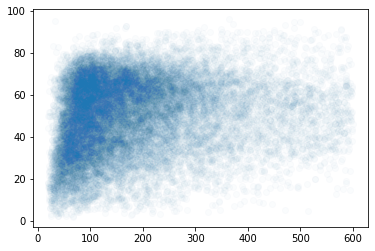

In [240]:
plt.scatter(df.tokensPerMinute, df.stickiness, alpha=0.02)

In [241]:
print(np.mean(df[df.time_class == 0].stickiness))
print(np.mean(df[df.time_class == 1].stickiness))

47.438530075135596
52.410163454072325


In [242]:
## Boxplots show the same thing

In [243]:
def show_boxplots(df):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.boxplot(df.pageviews)
    ax2.boxplot(df.nr_tokens)
    ax3.boxplot(df.avgTimeOnPagePerWordcount)

def show_histograms(df):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.hist(df.pageviews)
    ax2.hist(df.nr_tokens)
    ax3.hist(df.avgTimeOnPagePerWordcount)

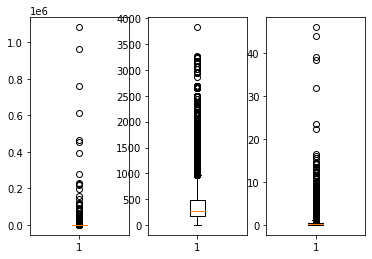

In [244]:
show_boxplots(df_full)

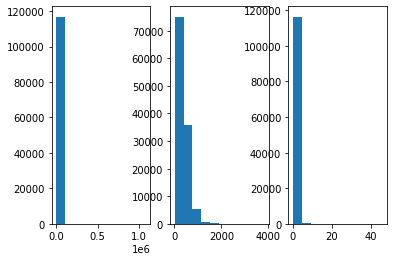

In [245]:
show_histograms(df_full)

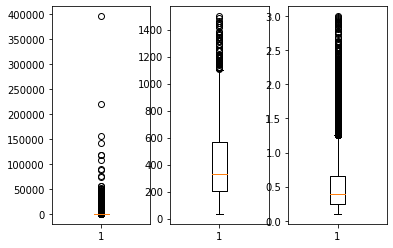

In [246]:
show_boxplots(df)

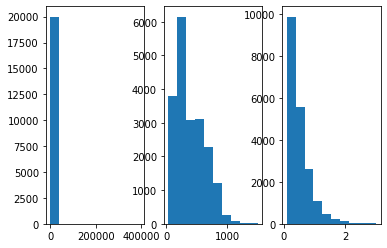

In [247]:
show_histograms(df)

## Conditioning on some thresholds (min_pageviews, ...)

In [134]:
df_50views = utils.get_conditioned_df(min_pageviews = 50,
                                   min_nr_tokens = 20,
                                   min_time = 0.001, # dummy
                                   max_time = 2,
                                   delete_outliers = True) # dummy


Shape of raw df: (116845, 44)
Remaining df after conditioning: (21678, 44)


In [135]:
df_50views.describe().round(3)

,articleId,pageviews,entrances,exits,bounces,timeOnPage,conversions,avgTimeOnPage,stickiness,entranceRate,bounceRate,wordcount,zeilen,nr_tokens,mean_token_length,nr_tokens_teaser,nr_tokens_titelH1,nr_char,nr_sentences,mean_sentence_length,avgTimeOnPagePerNr_tokens,avgTimeOnPagePerNr_char,pageviews-exits
count,2.167800e+04,21678.000,21678.000,21678.000,21678.000,2.167800e+04,0.0,21678.000,21678.000,21678.000,21678.000,21678.000,21678.000,21678.000,21678.000,21678.000,21678.000,21678.000,21678.000,21678.000,21678.000,21678.000,21678.000
mean,3.525498e+07,701.813,381.016,420.441,197.384,3.892947e+04,NaN,139.976,50.367,40.281,18.745,411.530,49.057,420.932,5.877,18.297,7.975,2935.829,24.559,17.508,0.450,0.065,281.372
std,2.248323e+07,4416.679,2914.977,3018.033,2016.991,2.322811e+05,NaN,82.209,17.297,22.327,18.343,250.478,30.600,256.777,0.386,15.737,1.821,1807.468,16.003,3.218,0.341,0.050,1830.946
min,1.780060e+06,50.000,0.000,2.000,0.000,3.600000e+01,NaN,1.134,1.770,0.000,0.000,47.000,0.000,46.000,4.351,0.000,1.000,324.000,2.000,5.745,0.003,0.000,2.000
25%,2.081045e+06,73.000,23.000,33.000,6.000,4.062000e+03,NaN,83.767,37.895,21.154,4.202,208.000,24.000,211.000,5.636,0.000,7.000,1473.000,12.000,15.372,0.204,0.029,37.000
50%,4.946547e+07,128.000,46.000,60.000,19.000,8.703000e+03,NaN,130.352,51.933,38.272,12.727,357.000,44.000,363.000,5.895,25.000,8.000,2560.500,21.000,17.143,0.355,0.051,66.000
75%,5.082473e+07,357.000,139.000,177.000,59.000,2.428125e+04,NaN,179.750,63.636,58.034,28.223,580.000,68.000,596.000,6.132,32.000,9.000,4142.000,34.000,19.226,0.606,0.087,175.000
max,5.346510e+07,395458.000,209521.000,207770.000,125977.000,2.514992e+07,NaN,1648.907,97.692,100.000,96.884,3263.000,425.000,3251.000,7.769,109.000,16.000,24448.000,238.000,43.091,1.998,0.334,229751.000


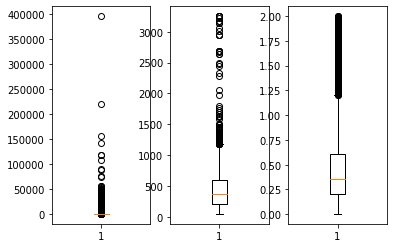

In [136]:
show_boxplots(df_50views)

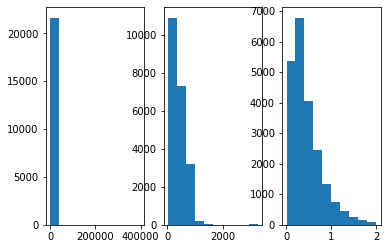

In [137]:
show_histograms(df_50views)

In [138]:
df_50views.quantile([.1,.2,.5,.8,.9])

,articleId,pageviews,entrances,exits,bounces,timeOnPage,conversions,avgTimeOnPage,stickiness,entranceRate,bounceRate,wordcount,zeilen,nr_tokens,mean_token_length,nr_tokens_teaser,nr_tokens_titelH1,nr_char,nr_sentences,mean_sentence_length,avgTimeOnPagePerNr_tokens,avgTimeOnPagePerNr_char,pageviews-exits
0.1,2002637.0,57.0,12.0,23.0,2.0,2047.0,NaN,49.018421,26.506024,11.764706,1.408451,149.0,17.0,152.0,5.369546,0.0,6.0,1042.7,9.0,13.892857,0.110798,0.015817,25.0
0.2,2058766.0,67.0,19.0,30.0,4.0,3377.0,NaN,72.518596,34.682255,18.085108,3.174603,189.0,22.0,192.0,5.564202,0.0,6.0,1338.0,11.0,14.976956,0.175720,0.025162,34.0
0.5,49465469.0,128.0,46.0,60.0,19.0,8703.0,NaN,130.351889,51.932949,38.271605,12.727273,357.0,44.0,363.0,5.895028,25.0,8.0,2560.5,21.0,17.142857,0.355499,0.051011,66.0
0.8,51385944.6,503.0,208.0,259.0,81.0,32854.8,NaN,193.547996,65.982858,62.092479,32.812500,626.0,74.0,643.0,6.193150,33.0,9.0,4482.0,37.0,19.750000,0.683102,0.097887,236.0
0.9,52120182.2,1259.0,600.3,682.0,204.0,72112.6,NaN,234.963990,71.373828,71.153846,45.326618,741.0,89.0,762.0,6.349206,37.0,10.0,5304.0,44.0,21.571429,0.908638,0.131724,549.0


In [140]:
# use thresholds
min_time = 0.1
max_time = 1

In [141]:
df_cond = utils.get_conditioned_df(min_pageviews = 50,
                                   min_nr_tokens = 20, # filter out flawed rows
                                   min_time = min_time, 
                                   max_time = max_time,
                                   delete_outliers = True)

/home/ruecker/miniconda3/envs/GPU/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3242: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Shape of raw df: (116845, 44)
Remaining df after conditioning: (18156, 44)


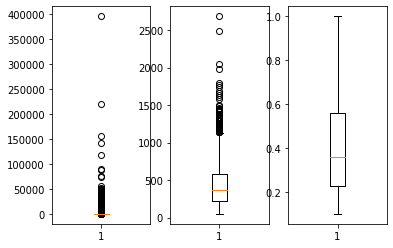

In [142]:
show_boxplots(df_cond)

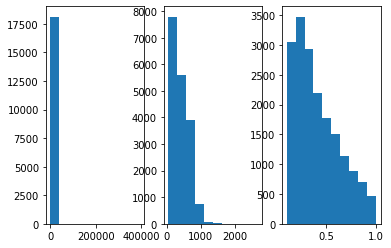

In [143]:
show_histograms(df_cond)

## Have a look at the one I used so far

In [32]:
df_used = utils.get_conditioned_df()

Shape of raw df: (104046, 42)
Remaining df after conditioning: (12743, 42)


In [33]:
df_used[display_columns].describe().round(3)

,pageviews,avgTimeOnPagePerNr_tokens,nr_tokens
count,12743.000,12743.000,12743.000
mean,1473.037,0.550,382.463
std,14008.741,0.389,247.365
min,100.000,0.100,23.000
25%,153.000,0.254,185.000
50%,288.000,0.435,301.000
75%,802.000,0.741,558.000
max,1061773.000,2.000,2685.000


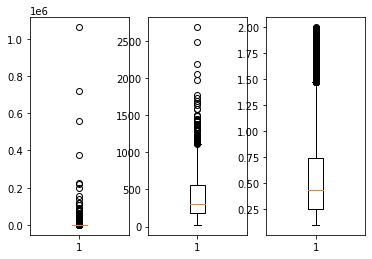

In [34]:
show_boxplots(df_used)

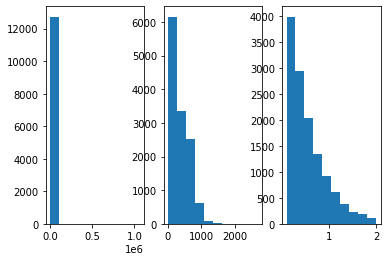

In [35]:
show_histograms(df_used)

## other way around: tokens per second

In [101]:
# delete the 7081 ones with avgTimeOnPage == 0 (no pageviews or just bounces)
df_time = df_full.drop(df_full[df_full.avgTimeOnPage == 0].index)

In [103]:
#df_time.head()

In [104]:
df_time['tokensPerSecond'] = df_time.nr_tokens / df_time.avgTimeOnPage

In [121]:
display_columns2 = display_columns + ['tokensPerSecond']
df_time[display_columns2].describe().round(3)

,pageviews,avgTimeOnPagePerNr_tokens,nr_tokens,tokensPerSecond
count,96963.000,96963.000,96963.000,96963.000
mean,261.456,0.419,353.680,36.095
std,6263.557,0.724,241.082,118.511
min,1.000,0.000,7.000,0.020
25%,8.000,0.084,175.000,2.014
50%,16.000,0.242,273.000,4.133
75%,47.000,0.497,501.000,11.835
max,1061773.000,49.889,3850.000,7700.000


Shows: Mean of 36 tokens per second can't be true. Median (4 tokens per second) seems more plausible.

In [124]:
df_used_time = utils.get_conditioned_df()
df_used_time['tokensPerSecond'] = df_used_time.nr_tokens / df_used_time.avgTimeOnPage

/home/ruecker/miniconda3/envs/GPU/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3242: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Shape of raw df: (104046, 42)
Remaining df after conditioning: (12743, 42)


In [125]:
df_used_time[display_columns2].describe().round(3)

,pageviews,avgTimeOnPagePerNr_tokens,nr_tokens,tokensPerSecond
count,12743.000,12743.000,12743.000,12743.000
mean,1473.037,0.550,382.463,2.944
std,14008.741,0.389,247.365,2.103
min,100.000,0.100,23.000,0.500
25%,153.000,0.254,185.000,1.349
50%,288.000,0.435,301.000,2.299
75%,802.000,0.741,558.000,3.934
max,1061773.000,2.000,2685.000,10.000


In [126]:
df_used_time[df_used_time.tokensPerSecond > 8]

,articleId,pageviews,entrances,exits,bounces,timeOnPage,conversions,avgTimeOnPage,stickiness,entranceRate,bounceRate,kategorie,rubrik,subRubrik,titel,pagePath,dpaGuid,categoryCode,genre,geoArea,keywords,links,subject,teaser,text,titelH1,titelH3,wordcount,category,publisher,city,text_preprocessed,nr_tokens,mean_token_length,nr_tokens_teaser,nr_tokens_titelH1,nr_char,nr_sentences,mean_sentence_length,avgTimeOnPagePerNr_tokens,avgTimeOnPagePerNr_char,pageviews-exits,tokensPerSecond
1506,48837349,812,292,304,119,62760,NaN,123.543307,62.561576,35.960591,14.655172,news,panorama,NaN,venedig-will-nach-hochwasser-wieder-mehr-touri...,https://www.general-anzeiger-bonn.de/news/pano...,200207-99-821511,dpacat:vm,Reportage,Italien,"Brauchtum__,__Karneval","MOSE Webseite__,__Prokurator Markusdom__,__Kom...","Wetter__,__Hochwasser__,__Tourismus",Karneval ist Hochsaison in Venedig. Doch diesm...,Venedig (dpa) - Auf dem Weg ins Untergeschoss ...,Wenn Venedig auf einmal die Touristen fehlen,NaN,1150.0,vm,bonn,Venedig,Auf dem Weg ins Untergeschoss des Markusdoms r...,1192,5.229866,35,7,7558,85.0,14.023529,0.103644,0.016346,508,9.648438
1741,48861161,297,103,116,66,19824,NaN,109.524862,60.942761,34.680135,22.222222,news,politik,deutschland,wie-weiter-in-thueringen_aid-48861161,https://www.general-anzeiger-bonn.de/news/poli...,200209-99-841924,dpacat:pl,Zusammenfassung,Deutschland,NaN,NaN,"Koalition__,__Landtag__,__Regierung","Erst einen neuen Ministerpräsidenten wählen, d...",Berlin/Erfurt (dpa) - Nach der gescheiterten M...,Wie weiter in Thüringen? - Parteien beraten we...,NaN,883.0,pl,bonn,Berlin/Erfurt,Nach der gescheiterten Ministerpräsidentenwahl...,911,5.721186,33,8,6208,43.0,21.186047,0.120225,0.017643,181,8.317746
1883,48886139,255,59,73,34,19139,NaN,105.159341,71.372549,23.137255,13.333333,news,politik,deutschland,kramp-karrenbauer-und-scholz-setzen-auf-die-ko...,https://www.general-anzeiger-bonn.de/news/poli...,200211-99-873122,dpacat:pl,Zusammenfassung,Deutschland,"CDU__,__CSU__,__SPD",NaN,"Partei__,__Koalition",Der angekündigte Rückzug von Annegret Kramp-Ka...,Berlin (dpa) - Die CDU-Vorsitzende Annegret Kr...,Kramp-Karrenbauer beim Zeitplan für CDU-Führun...,NaN,869.0,pl,bonn,Berlin,Die CDU-Vorsitzende Annegret Kramp-Karrenbauer...,917,5.906216,34,7,6393,41.0,22.365854,0.114678,0.016449,182,8.720100
3704,49193301,297,62,80,30,23560,NaN,108.571429,73.063973,20.875421,10.101010,news,politik,deutschland,politischer-aschermittwoch-in-bewegten-zeiten_...,https://www.general-anzeiger-bonn.de/news/poli...,200226-99-83722,dpacat:pl,KORR-Bericht,Deutschland,Aschermittwoch,Im dpa-Shop verfügbar: Liveblog zum politische...,"Partei__,__Brauchtum","Hanau, Volkmarsen, Corona und die CDU-Führungs...",Passau/Landshut (dpa) - Wie ernst die Lage für...,Aschermittwoch 2020: Machtverschiebung auf gro...,NaN,872.0,pl,bonn,Passau/Landshut,"Wie ernst die Lage für die Union ist, erweist ...",902,5.273836,24,6,5744,39.0,23.128205,0.120367,0.018902,217,8.307895
7365,49819261,127,35,48,25,7915,NaN,100.189873,62.204724,27.559055,19.685039,news,politik,ausland,unhcr-wegen-corona-fluechtlingslager-auf-insel...,https://www.general-anzeiger-bonn.de/news/poli...,200329-99-513300,dpacat:pl,KORR-Bericht,"Griechenland__,__Türkei","EU__,__Corona__,__Covid-19",Aktuelle Flüchtlingszahlen auf den griechische...,"Migration__,__Flüchtling__,__Krankheit__,__Ges...","Zahlreiche Hilfsorganisationen fordern, die Fl...",Athen/Lesbos/Istanbul (dpa) - Inmitten von Mül...,Corona auf Flüchtlingsinseln «nur noch eine Fr...,NaN,886.0,pl,bonn,Athen/Lesbos/Istanbul,"Inmitten von Müll, Schlamm und Gestank zu lebe...",895,5.746369,34,11,6149,41.0,21.829268,0.111944,0.016294,79,8.933039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97322,51617719,1251,666,688,22,23565,NaN,41.856128,45.003997,53.237410,1.758593,nachrichten,wirtschaft,NaN,ueberbrueckungshilfen-fuer-